**Example using Dynamic Time Warping for clustering. **

In [1]:
from itertools import combinations
import math
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix
import scipy
import pylab
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [2]:
def l2(xi, yi):
    return (xi - yi)**2

def dtw_fn(x, y):
    """ Compute dynamic time warping distances for two time series x and y."""
    r, c = len(x), len(y)
    max_window = 10 # max search window (smaller->more efficient but less exact)
    w = max(max_window, abs(r - c))  
    D = np.ones((r + 1, c + 1)) * np.inf
    D[0, 0] = 0.

    for i in range(r):
        for j in range(max(0, i - w), min(c, i + w)):
            D[i+1, j+1] = l2(x[i], y[j])

    for i in range(r):  # why loop twice?!!
        for j in range(max(0, i - w), min(c, i + w)):
            D[i+1, j+1] += min(D[i, j], D[i, j+1], D[i+1, j])

    D = D[1:, 1:]
    return math.sqrt(D[-1, -1])

In [3]:
# Example.
dtw_fn([0,2,1,1.5], [0,0,2,1,1,1])

0.5

In [4]:
def dtw(X):
    """ Compute dtw for all pairs of rows in a matrix."""
    distances = np.zeros((len(X), len(X)))
    for i, j in combinations(range(len(X)), 2):
        distances[i,j] = dtw_fn(X[i], X[j])
    return distances

In [5]:
# Sample data.
X = np.array([[0,1,2,3], [1,2,3],
              [5,9,5,0,5], [5,4,2,0,4],
              [6,2,1], [1, 9, 6, 8]])

In [6]:
# Pad each row with leading zeros to make all have same length.
def pad_data(X):
    max_len = max(len(i) for i in X)
    Xnew = np.zeros((len(X), max_len))
    for i, row in enumerate(X):
        diff = max_len - len(row)
        if diff > 0:
            Xnew[i] = np.concatenate(([0] * (diff), row))
        else:
            Xnew[i] = row
    return Xnew
X = pad_data(X)
X

array([[ 0.,  0.,  1.,  2.,  3.],
       [ 0.,  0.,  1.,  2.,  3.],
       [ 5.,  9.,  5.,  0.,  5.],
       [ 5.,  4.,  2.,  0.,  4.],
       [ 0.,  0.,  6.,  2.,  1.],
       [ 0.,  1.,  9.,  6.,  8.]])

In [84]:
# Cluster into 3 clusters using DTW.
from sklearn.cluster import AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters=5, affinity=dtw, linkage='average')
#clusters = clusterer.fit_predict(X)


In [85]:
def find_centroids(X, clusters):
    """Find the centroid of each cluster, defined as the cluster element that
    has the lowest distance to all other elements in the cluster. """
    clusterids = set(clusters)
    cluster2centroid = dict()
    soma=float()
    idd=0
    for clusterid in clusterids:
        #print(clusterids)
        cluster = np.where(clusters == clusterid)[0]
        #print(cluster)
        distances = dtw(X[cluster])
        #print('di', distances,'\n')
        #print(X[cluster])
        for row,l in enumerate(distances):
            #print('l',l)
            #print('row',row)
            if l.sum() <= soma:
                #print(l.sum(), '<', soma)
                soma=l.sum()
                idd=row
        #print('idd',idd)
        centroid = cluster[idd]
        #centroid = cluster[np.argmin(row.sum() for row in distances)]#jusst get cluster[0]
        #print('ks',[np.argmin(row.sum() for row in distances)])
        #print('cent',centroid)
        #print('realcent', X[centroid])
        cluster2centroid[clusterid] = centroid
        #print(cluster2centroid)
    return cluster2centroid
#cluster2centroid = find_centroids(X, clusters)
#cluster2centroid

In [9]:
import pickle
DIR= '/home/elaine/Protest/protest/Brazil project/'
pkl_file = open(DIR+'dictionaryofresults.pkl', 'rb')#open pickle file where the edges of the graph is saved
data1 = pickle.load(pkl_file)

In [46]:
for k,v in data1.items():
    print(k,v)
    break

mais_velho [0.46140693686193468, 0.45907216828313518, 0.45934747013379185]


In [238]:
users = defaultdict(list)
for k, v in data1.items():
    if len(v)>3:
        users[k]=v

In [53]:
new=pad_data(data1.values())
print(len(new))


242


In [72]:
distances = dtw(new)

In [86]:
clusters = clusterer.fit_predict(distances)
print(clusters)

[3 0 4 3 0 3 0 3 0 3 4 3 4 4 3 4 0 0 0 3 4 3 4 4 3 4 3 4 4 3 0 3 3 3 3 3 0
 3 3 0 3 3 0 0 0 0 3 0 3 3 3 0 0 3 3 3 0 3 3 3 3 3 3 0 3 0 0 0 3 0 3 0 0 3
 3 3 0 3 2 2 2 3 3 2 3 3 2 3 3 3 3 3 2 2 2 2 2 2 3 2 2 3 3 2 3 2 2 2 3 3 2
 3 3 2 2 2 3 2 2 2 3 2 2 3 2 2 2 1 2 2 2 1 2 1 2 1 2 1 2 1 2 1 1 2 1 2 1 2
 2 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [87]:
cluster2centroid = find_centroids(new, clusters)

In [88]:
cluster2centroid


{0: 76, 1: 241, 2: 157, 3: 123, 4: 28}

In [89]:
#find who are the centroids
ar=[]
ar = [d for d in data1.items()]

for c,d in enumerate(ar):
    if c in cluster2centroid.values():
        print(c,d[0])

28 vjukac
76 ViviFreitas17
123 MovBrasillivre
157 danielrlemos
241 KarenFreittas


In [19]:
DIR = '/home/elaine/Protest/protest/Brazil project/'
pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
data = pickle.load(pkl_file)

In [20]:
data.neighbors('arrobateus')

['gustavokaetano',
 'um_marginal',
 'Sufiatti',
 '_jehlemos',
 'arrombadorr',
 'Alessandro1709',
 'fresnalizei']

In [59]:
def plot_probs(dictv):
    %pylab inline
    fig = plt.figure(figsize=(40,10))
    print(len(dictv))
    for k, v in dictv.items():
        #if k == name:
        i=1
        y=[]
        x=[]
        t = 1/len(dictv[k])
        for g in dictv[k]:
            y.append(g)
            x.append(i*t)
            i = i+1
        plt.xlabel('% of total tweets')
        plt.ylabel('Probability')
        plt.plot(x,y)
    #plt.savefig(name)

In [94]:
from collections import defaultdict
newdic = defaultdict(list)
for item in zip(clusters,data1.items()):
    #print(item[0],item[1][0])
    if item[0] == 4:
    #print(item[1])
    #plot_probs(data1, item[1])
        newdic[item[1][0]]=item[1][1]
print(len(newdic))

11


Populating the interactive namespace from numpy and matplotlib
105


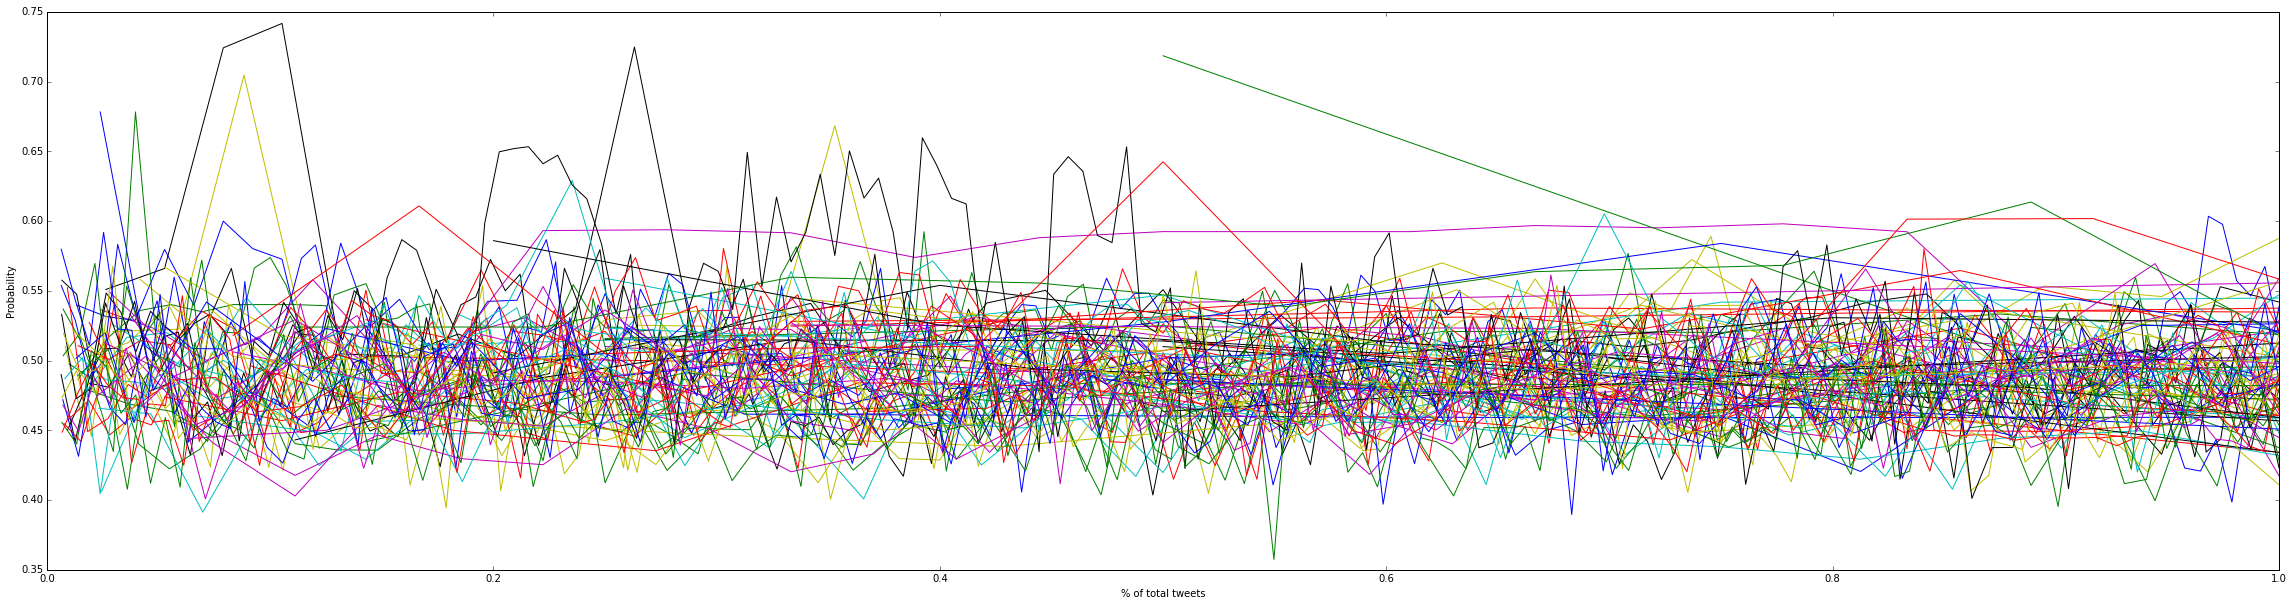

In [62]:
plot_probs(newdic)

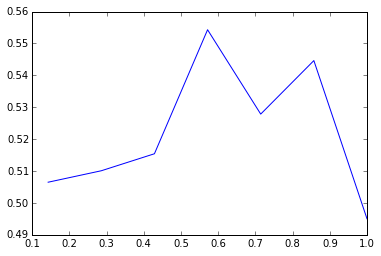

In [243]:
def plot_centroid(newdic, name):
    t = 1/len(newdic[name])
    x=[]
    y=[]
    i=1
    for g in newdic[name]:
        y.append(g)
        x.append(i*t)
        i = i+1
    plt.plot(x,y)
plot_centroid(newdic, 'BR45IL100PT')

In [69]:
finaldic= defaultdict(list)
for n,v in newdic.items():
    #n == 'MandinhaSimone' or or n == 'hxf25'n == 'ariadnimariano' or n == 'LuxAjuda' or n == 'FilipeBitch' or
    #print(n)
    if(  n== 'danielrlemos'   or n == 'KarenFreittas'or n=='flaviorodgomes'or n=='ViviFreitas17' ):
        finaldic[n]=v

Populating the interactive namespace from numpy and matplotlib
4


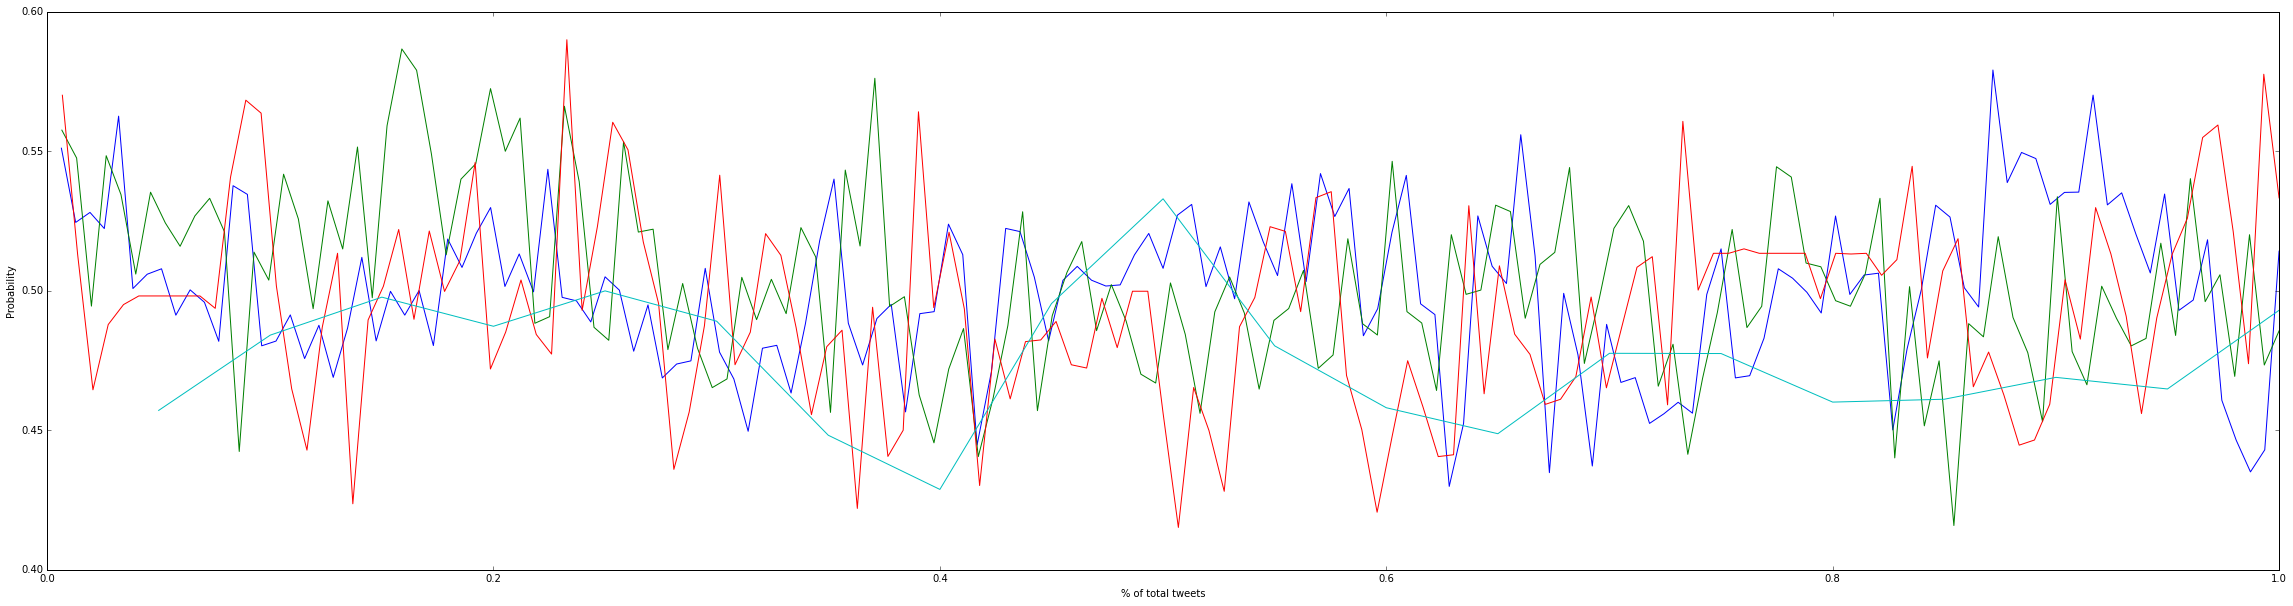

In [70]:
plot_probs(finaldic)
#print(finaldic)

In [548]:
finaldic.keys()

dict_keys(['cassiosalva', 'Moreira_Angella', 'Ary_AntiPT'])

Populating the interactive namespace from numpy and matplotlib


KeyboardInterrupt: 

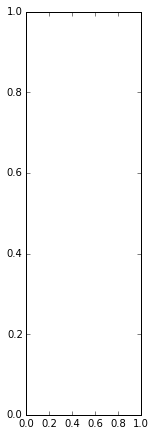

In [40]:
%pylab inline
#import  as s

# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09,0.1,0.2,0.7])
Y = sch.linkage(new, method='average', metric=dtw_fn)
Z1 = sch.dendrogram(Y, orientation='right')
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.81,1.6,0.2])
Y = sch.linkage(new, method='average')
Z2 = sch.dendrogram(Y)
ax2.set_xticks([])
ax2.set_yticks([])


#Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,1.6,0.7])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
new = new[idx1,:]
new = new[:,idx2]
im = axmatrix.matshow(new, aspect='auto', origin='lower', cmap=pylab.cm.Blues)
#axmatrix.set_xticks([])
#axmatrix.set_yticks([])
#axmatrix.set_xticks(range(242))
"""print(len(idx1))
axmatrix.set_xticklabels(idx1, minor=False)
axmatrix.xaxis.set_label_position('bottom')
axmatrix.xaxis.tick_bottom()

pylab.xticks(rotation=-90, fontsize=8)

#axmatrix.set_yticks(range(242))
axmatrix.set_yticklabels(idx2, minor=False)
axmatrix.yaxis.set_label_position('right')
axmatrix.yaxis.tick_right()

# Plot colorbar.
axcolor = fig.add_axes([1.95,0.1,0.02,0.7])
pylab.colorbar(im, cax=axcolor)
fig.show()
fig.savefig('dendrogram.png')"""

In [25]:
#ax1 = fig.add_axes([0.09,0.1,1.8,0.6])
Y = sch.linkage(new, method='average', metric=dtw_fn)
#print(type(Y))

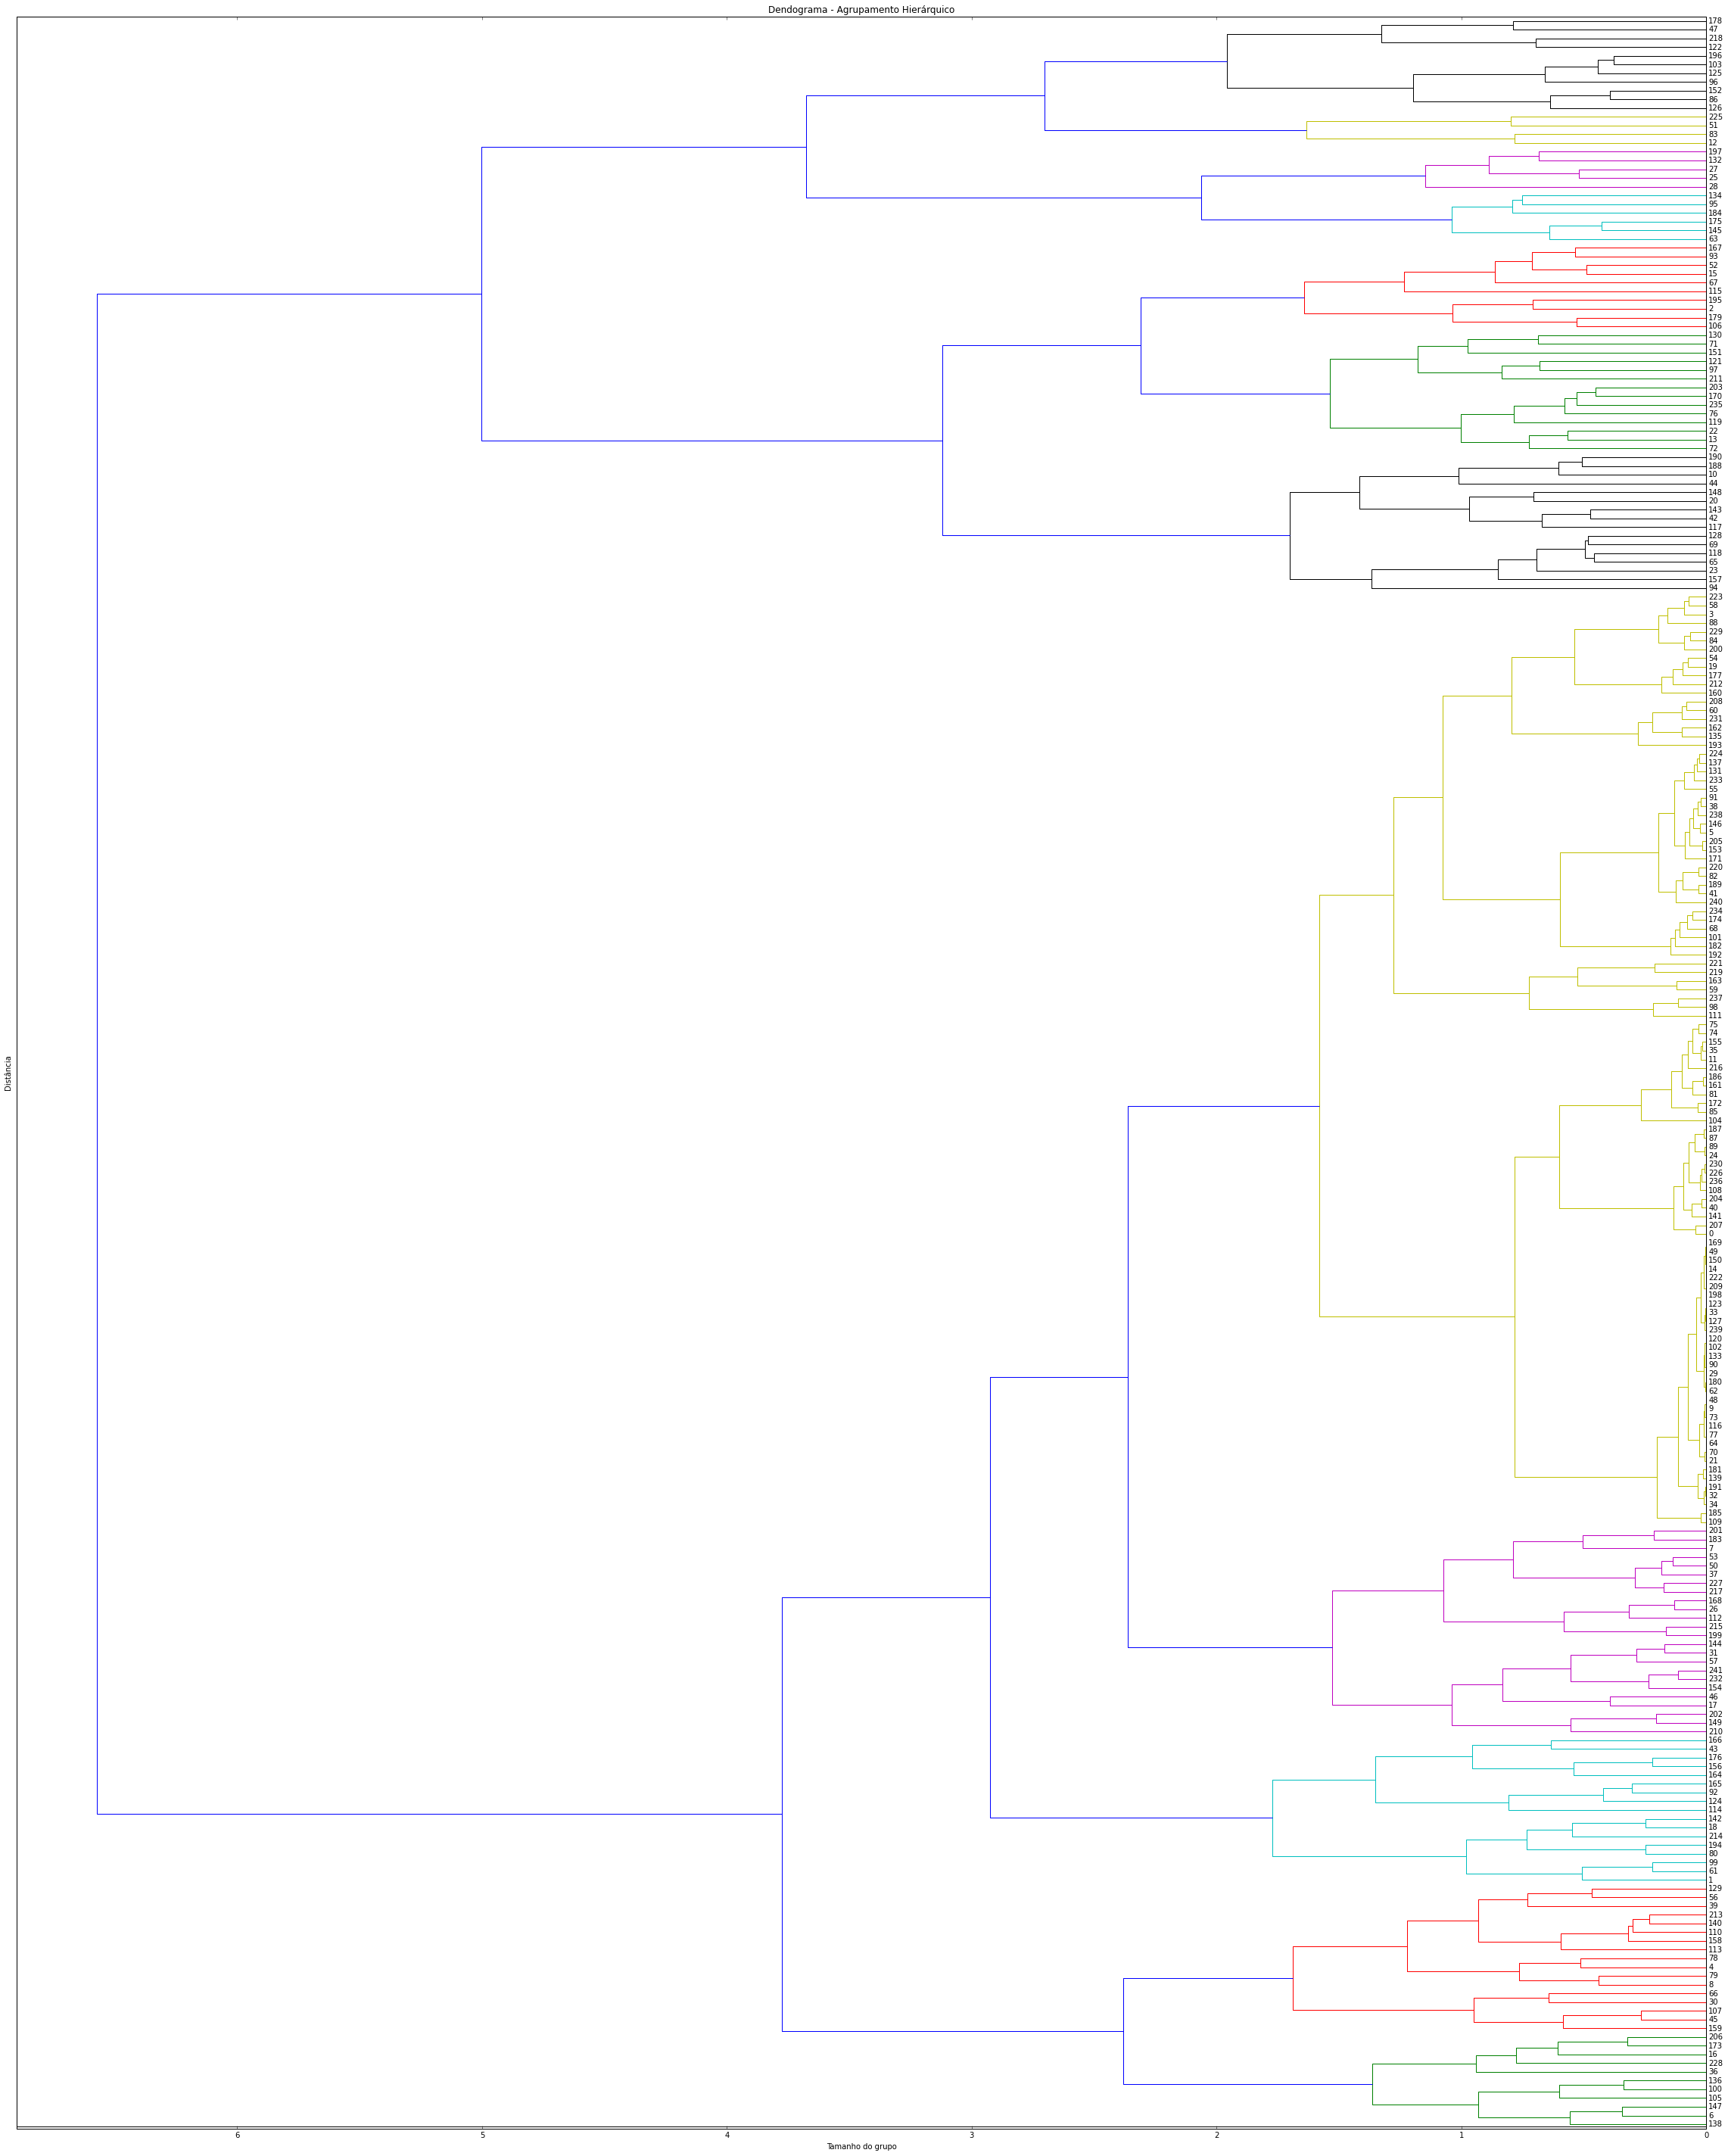

In [23]:
fig = plt.figure(figsize=(40,50))

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

fancy_dendrogram(Y, leaf_rotation=70,leaf_font_size=7, orientation='right',annotate_above=10,max_d=2)
#ax1.set_xticks([])
#ax1.set_yticks([])
plt.show()

In [28]:
fig = plt.figure(figsize=(10,10))
sch.dendrogram(Y, leaf_rotation=70,leaf_font_size=7, orientation='top', show_leaf_counts=True, 
               show_contracted=True, truncate_mode='lastp', p=12)
#ax1.set_xticks([])
#ax1.set_yticks([])
plt.show()

In [26]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sch.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendograma - Agrupamento Hierárquico ')#Hierarchical Clustering Dendrogram ')
        plt.xlabel('Tamanho do grupo')
        plt.ylabel('Distância')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

Populating the interactive namespace from numpy and matplotlib


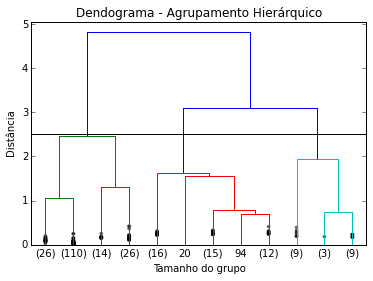

In [65]:
%pylab inline
fancy_dendrogram(
    Y,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=2.5  # plot a horizontal cut-off line
)
plt.show()

In [28]:
from scipy.cluster.hierarchy import fcluster
max_d = 2.3
clusters = fcluster(Y, max_d, criterion='distance')
clusters

array([1, 2, 3, 1, 2, 1, 2, 1, 2, 1, 3, 1, 4, 3, 1, 3, 2, 1, 1, 1, 3, 1, 3,
       3, 1, 3, 1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 2, 3, 2,
       1, 4, 1, 1, 1, 4, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 4, 1, 3, 2, 3, 1,
       3, 1, 3, 3, 1, 1, 1, 3, 1, 2, 2, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1,
       2, 3, 3, 4, 4, 3, 1, 2, 2, 1, 1, 4, 1, 2, 3, 2, 1, 1, 2, 1, 1, 2, 2,
       3, 1, 3, 3, 3, 1, 3, 4, 1, 2, 4, 4, 1, 3, 2, 3, 1, 3, 1, 4, 1, 2, 1,
       2, 1, 2, 1, 1, 3, 1, 4, 1, 2, 3, 1, 1, 3, 4, 1, 1, 1, 2, 3, 2, 2, 1,
       1, 1, 1, 2, 2, 2, 3, 1, 1, 3, 1, 1, 2, 1, 4, 2, 1, 4, 3, 1, 1, 1, 1,
       4, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 4, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2,
       1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1], dtype=int32)

In [29]:
cluster2centroid = find_centroids(new, clusters)

In [30]:
cluster2centroid

{1: 241, 2: 228, 3: 235, 4: 225}

In [17]:
from collections import defaultdict
newdic = defaultdict(list)
for item in zip(clusters,data1.items()):
    #print(item[0],item[1][0])
    if item[0] == 1:
    #    print(item[1])
        #plot_probs(data1, item[1])
        newdic[item[1][0]]=item[1][1]

Populating the interactive namespace from numpy and matplotlib
31


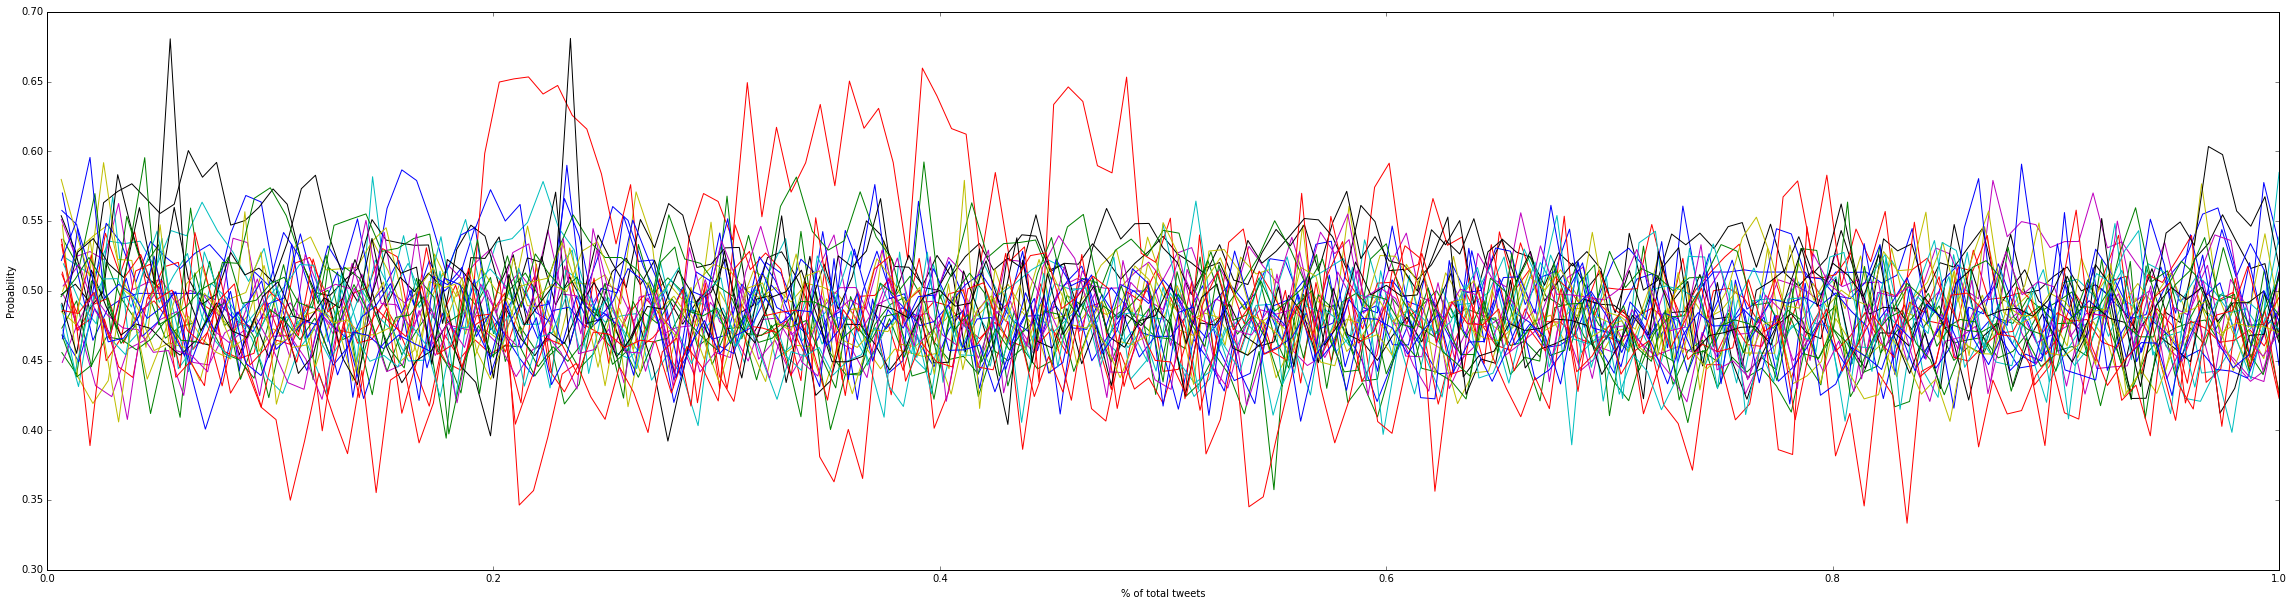

In [59]:
plot_probs(newdic)

In [26]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Y, pdist(new, metric=dtw_fn))
print(Y[0])

[  9.70000000e+01   9.80000000e+01   6.08194529e-06   2.00000000e+00]


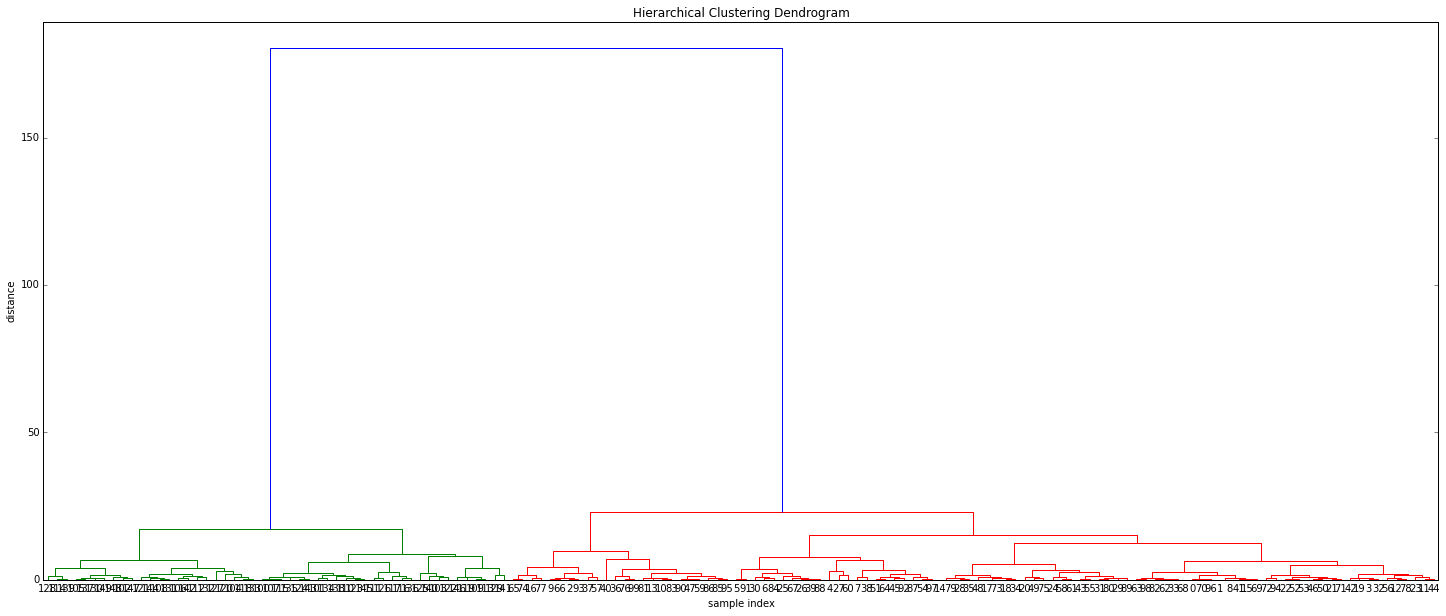

In [84]:
from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
a=linkage(X, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    a,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [85]:
X[:,0]

array([  9.21188389e+00,   8.88937431e+00,   1.07684006e+01,
         8.24213268e+00,   5.79670090e+00,   6.34993090e+00,
         8.10571230e+00,   8.72084884e+00,   8.83500513e+00,
         1.04006121e+01,   1.19550340e+01,   8.50141850e+00,
         9.23359190e+00,   1.22776800e+01,   1.09590184e+01,
         8.72437412e+00,   9.64949127e+00,   1.14991208e+01,
         1.14825643e+01,   8.58740424e+00,   1.19557043e+01,
         9.85622312e+00,   1.01183101e+01,   7.76042253e+00,
         1.09979416e+01,   6.90850201e+00,   7.85787065e+00,
         6.12508463e+00,   1.06114379e+01,   1.10921749e+01,
         7.15906941e+00,   1.07378401e+01,   8.23931855e+00,
         9.83913054e+00,   1.12622203e+01,   1.06780159e+01,
         1.39081564e+01,   1.12197936e+01,   9.08490874e+00,
         7.77229101e+00,   1.63633299e+01,   8.81582877e+00,
         8.13179077e+00,   1.01349908e+01,   8.59430666e+00,
         8.98565337e+00,   9.86312125e+00,   1.22599442e+01,
         1.21914459e+01,

In [37]:
X[1]

array([ 8.88937431, -0.33937464])